In [14]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('dark_background')
%matplotlib inline

from option import Option
from process import GeometricBrownianMotion, HestonProcess
from pricing import monte_carlo_simulation, monte_carlo_simulation_LS, black_scholes_merton, crr_pricing#, heston_semi_closed

The option file contains class representing derivative options <br>
The process file contains class representing stocastic models <br>
The pricing file contains functions for pricing derivatives using different techniques

# Classic Monte Carlo

## Simulation

First let's use the GeometricBrownianMotion class to simulation some GBM paths. This class use the available closed form formula of the GBM stocastic process
$$ 
dS_t = \mu S_t dt +  \sigma S_t dW_t
$$
Using the solution of this SDE, we can use numpy vectorization to simulate the paths in an efficient way. This allow us to simulate a good number of paths quite rapidly

In [5]:
gmb = GeometricBrownianMotion(mu=0.05, sigma=0.2)
gmb

GeometricBrownianMotion(mu=0.05, sigma=0.2)

In [6]:
%time test = gmb.simulate(s0=60, T=1, n=200_000, m=252)

Wall time: 4.97 s


Only 5 sec to generate 200k paths

Now we can display the results of the simulation. Let's plot 10 simulated GBM paths

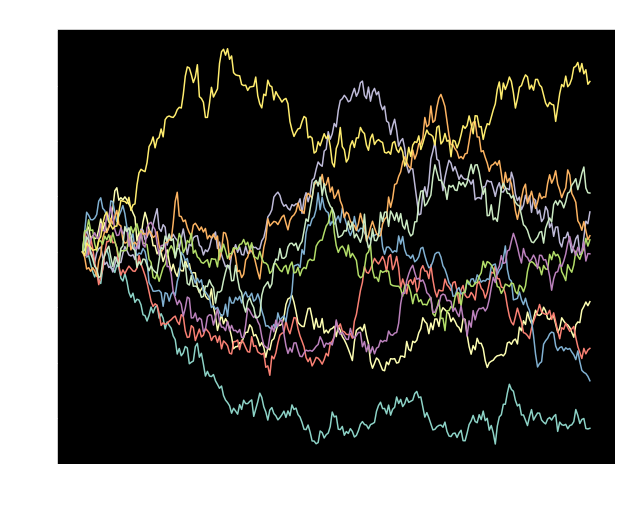

In [7]:
S = gmb.simulate(s0=60, T=1, n=10, m=252)  # n = number of path, m = number of discretization points

plt.figure(figsize=(10, 8))
plt.plot(S)
plt.xlabel('$t$', fontsize=20)
plt.ylabel('$S_t$', fontsize=20, labelpad=20).set_rotation(0)
plt.title('Simulation of 10 GBM paths', fontsize=15, pad=10)
# plt.xlim(-10, 280)
plt.show()

## Monte Carlos price estimation 

Now we use the Option class to represente the parameters of an option derivative 

In [5]:
call = Option(s0=60, T=1, K=80, call=True)
put = Option(s0=60, T=1, K=80, call=False)
call

Option(s0=60, T=1, K=80, v0=None, call=True)

With both an option and a process representing the dynamic of the underlying, we can use the classic Monte Carlo method to approximate the price of the option. For this, we use the monte_carlo_simulation function from the custom princing module.

In [13]:
%time price = monte_carlo_simulation(option=call, process=gmb, n=200_000, m=252)
%time price = monte_carlo_simulation(option=put, process=gmb, n=200_000, m=252)

The price of Option(s0=60, T=1, K=80, v0=None, call=True) = 0.77
95.0% confidence interval = [0.76, 0.79]
Wall time: 5.15 s
The price of Option(s0=60, T=1, K=80, v0=None, call=False) = 16.86
95.0% confidence interval = [16.82, 16.91]
Wall time: 4.86 s


Now let's compare these results with the closed form formula of a vanilla call and put options when the underlying follows a GMB process. For this we use the black_scholes_merton function

In [7]:
call_price = black_scholes_merton(r=0.05, sigma=0.2, option=call)
put_price = black_scholes_merton(r=0.05, sigma=0.2, option=put)

print(f'Theorical price of the call option = {call_price}')
print(f'Theorical price of the put option = {put_price}')

Theorical price of the call option = 0.77
Theorical price of the put option = 16.87


Very close !

# Longstaff-Schwartz applied to the Heston model 

## Heston process simulation

We will now try to estimate the price of an american option in the Heston framework:<br><br>

$$ 
\begin{cases}
dS_t = \mu S_t dt + \sqrt{v_t} S_t dW^1_t \\
dv_t = \kappa (\theta - v_t) dt + \eta \sqrt{v_t} dW^2_t \\
dW^1_t dW^2_t = \rho dt
\end{cases}
$$

<br>
Like for the GBM process, we use the HestonProcess class to simulte an Heston process numerically. The paths are simulated using the Milstein schema of discretization. As opposite to the first process, it is not possible to fully vectorize the calculation of the paths. Thus, the simulation takes much longer than for the GeometricBrownianMotion class.

In [3]:
heston = HestonProcess(mu=0.06, kappa=0.0005, theta=0.04, eta=0.1, rho=-0.5)
heston

HestonProcess(mu=0.06, kappa=0.0005, theta=0.04, eta=0.1, rho=-0.5)

In [9]:
%time test = heston.simulate(s0=60, v0=0.05, T=1, n=5_000, m=252)

Wall time: 8.39 s


More than 10 sec for 5k paths vs 5 sec for 200k with the GMB process

Now we can display the results of the simulation. Let's plot 10 simulated paths

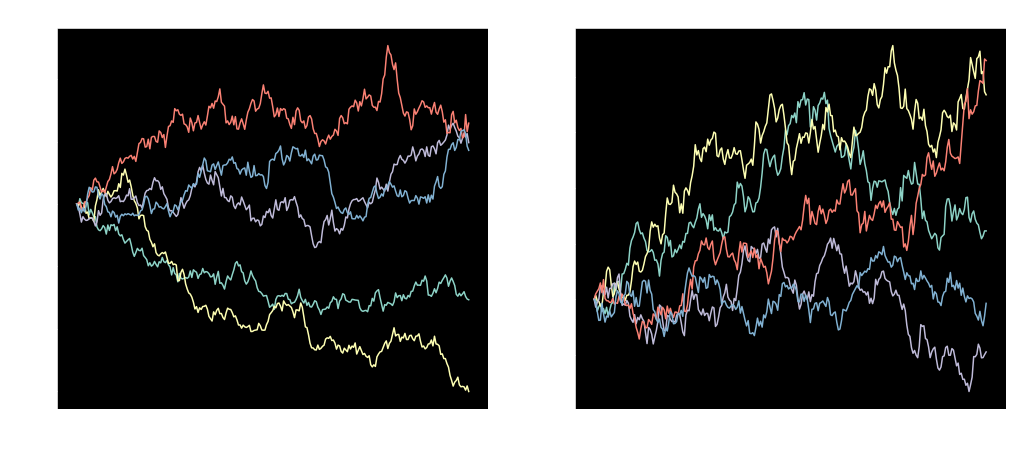

In [4]:
s, v = heston.simulate(s0=60, v0=0.05, T=1, n=5, m=252, return_vol=True)

plt.figure(figsize=(17, 7))
plt.subplot(1, 2, 1)
plt.plot(s)
plt.xlabel('$t$', fontsize=20)
plt.ylabel('$S_t$', fontsize=20, labelpad=20).set_rotation(0)
plt.title('Simulation of 5 Heston paths', fontsize=15, pad=10)
# plt.xlim(-10, 280)

plt.subplot(1, 2, 2)
plt.plot(v)
plt.xlabel('$t$', fontsize=20)
plt.ylabel('$v_t$', fontsize=20, labelpad=20).set_rotation(0)
plt.title('Underlying volatility process', fontsize=15, pad=10)

plt.show()

## Longstaff-Schwartz
<br><br>
Now we use the Longstaff-Schwartz algorithm to evaluate the price of the americain put options.<br><br>
The algorithm estimate the price of an americain option in a backward induction manner, just like in a CRR tree. We take discretization nodes = possible dates of exercise for the sake of simplicity. At each node of discretization, we fit a polynome (using the Polynome class from numpy) between the silumated paths and the discounted continuation value at the next step in time. Then the current continuation value is estimated using the parametres of the fitted polynome. <br><br>
For this implementation we use all the paths even though Longstaff and Schwartz pointed that using only the in-the-money paths is probably more efficient. The algorithm is implemented in the monte_carlo_simulation_LS function

In [68]:
heston_1 = HestonProcess(mu=0.06, kappa=0.0005, theta=0.04, eta=0.1, rho=-0.5)
heston_2 = HestonProcess(mu=0.10, kappa=0.0005, theta=0.04, eta=0.1, rho=-0.5)

put_1 = Option(s0=36, v0=0.04, T=1, K=40, call=False)
put_2 = Option(s0=50, v0=0.16, T=0.4167, K=50, call=False)

# %time monte_carlo_simulation_LS(option=put_1, process=heston_1, n=25_000, m=252)
# %time monte_carlo_simulation_LS(option=put_2, process=heston_2, n=25_000, m=252)

##  Cox, Ross and Rubinstein tree control method of the LS implementation
<br><br>
We can control the implementation of the monte_carlo_simulation_LS function by using an GBM process and comparing the results with a simple CRR tree. Like the Longstaff and Schwartz this algorithm work in a backward manner. The CRR tree pricing method is implemented in the crr_pricing function.

In [4]:
gmb_1 = GeometricBrownianMotion(mu=.06, sigma=.2)
gmb_2 = GeometricBrownianMotion(mu=.1, sigma=.4)

%time monte_carlo_simulation_LS(option=put_1, process=gmb_1, n=25_000, m=252)
%time monte_carlo_simulation_LS(option=put_2, process=gmb_2, n=25_000, m=252)

The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.4415
Wall time: 2.48 s
The price of Option(s0=50, T=0.4167, K=50, v0=0.16, call=False) = 4.1764
Wall time: 2.57 s


4.176

In [5]:
crr_1 = crr_pricing(r=.06, sigma=.2, option=put_1, n=25_000)
crr_2 = crr_pricing(r=.10, sigma=.4, option=put_2, n=25_000)

print(f'The price of the put_1 option estimated via a crr tree = {crr_1}')
print(f'The price of the put_2 option estimated via a crr tree = {crr_2}')

The price of the put_1 option estimated via a crr tree = 4.487
The price of the put_2 option estimated via a crr tree = 4.284


## Controle of Heston simulation using semi-closed form

We can control the simulation of the heston paths by comparing the value of a put option calculated by classic monte carlo and the semi-closed form provided by heston. To calculate the value of the option with the semi-closed form we use the heston_semi_closed function.

In [6]:
%time price_1 = heston_semi_closed(option=put_1, process=heston_1)
%time price_2 = heston_semi_closed(option=put_2, process=heston_2)

print(f'The price of {put_1} using Heston semi closed form = {price_1}')
print(f'The price of {put_2} using Heston semi closed form = {price_2}')

Wall time: 55.4 ms
Wall time: 66.3 ms
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) using Heston semi closed form = 3.758
The price of Option(s0=50, T=0.4167, K=50, v0=0.16, call=False) using Heston semi closed form = 4.074


In [72]:
%time price_1 = heston_semi_closed(option=put_1, process=heston_1)
%time price_2 = heston_semi_closed(option=put_2, process=heston_2)

print(f'The price of {put_1} using Heston semi closed form = {price_1}')
print(f'The price of {put_2} using Heston semi closed form = {price_2}')

Wall time: 779 ms
Wall time: 636 ms
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) using Heston semi closed form = 3.757
The price of Option(s0=50, T=0.4167, K=50, v0=0.16, call=False) using Heston semi closed form = 4.073


In [5]:
%time price = monte_carlo_simulation(option=put_1, process=heston_1, n=40_000, m=252)
%time price = monte_carlo_simulation(option=put_2, process=heston_2, n=40_000, m=252)

The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 3.76
95.0% confidence interval = [3.71, 3.8]
Wall time: 2min
The price of Option(s0=50, T=0.4167, K=50, v0=0.16, call=False) = 4.05
95.0% confidence interval = [4.0, 4.11]
Wall time: 1min 24s


# SANDBOX 

We can also check than the LS price converge to the result of the tree when the vol vol of the heston process goes to 0

The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 3.9793
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 3.9831
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 3.9858
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.0186
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.0622
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.1406
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.2393
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.324
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.4008
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.4487


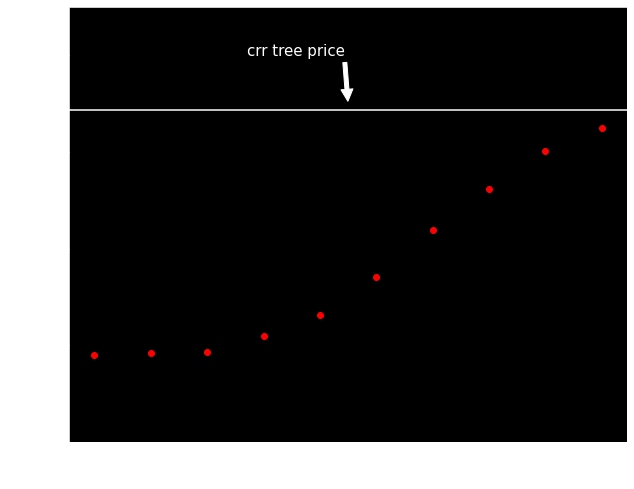

In [6]:
eta_list = np.linspace(0, 0.5, 10)[::-1]

plt.figure(figsize=(10, 8))

for eta in eta_list:

    heston = HestonProcess(mu=0.06, kappa=0.0005, theta=0.04, eta=eta, rho=-0.5)
    price = monte_carlo_simulation_LS(option=put_1, process=heston, n=200_000, m=20)
    plt.scatter(eta, price, c='r')

plt.axhline(y=4.487)
plt.annotate('crr tree price', xy=(0.25, 4.5), xycoords='data', xytext=(0.35, 4.6),
             arrowprops=dict(facecolor='white', shrink=0.05), fontsize=15)
plt.gca().invert_xaxis()
plt.xlabel('$\eta$', fontsize=20)
plt.ylabel('LS Option value', fontsize=20, labelpad=20)
plt.ylim(3.8, 4.7)
plt.show()

In [10]:
put = Option(s0=36, v0=0.04, T=1, K=40, call=False)
gmb = GeometricBrownianMotion(mu=.06, sigma=.2)
heston = HestonProcess(mu=0.06, kappa=0.0005, theta=0.04, eta=0.1, rho=-0.5)

price_crr = crr_pricing(r=.06, sigma=.2, option=put, n=25_000)

n = 100
price_ls_list = []
price_cd_list = []

for i in range(1, 100):

    price_gmb, X = monte_carlo_simulation_LS(option=put, process=gmb, n=n, m=100, return_all=True, seed=i)
    price_heston, Y = monte_carlo_simulation_LS(option=put, process=heston, n=n, m=100, return_all=True, seed=i)

    cov = np.cov(X, Y)[0, 1]
    var_x = np.cov(X, Y)[1, 1]
    c_star = cov/var_x

    print(c_star)

    price_cd = price_heston - c_star * (price_gmb - price_crr)

    price_ls_list.append(price_heston)
    price_cd_list.append(price_cd)

results = pd.DataFrame({f'Standard estimator (Var = {np.round(np.var(price_ls_list), 3)})': price_ls_list, 
                        f'Control variate estimator (Var = {np.round(np.var(price_cd_list), 3)})': price_cd_list})

The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.525
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.9379
-0.18355292944034104
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 5.6682
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.211
-0.41479783702830136
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 5.6211
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.635
-0.46047193948537885
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.6513
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.8797
-0.2555964088494894
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 5.0903
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.9535
-0.3700834387974257
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.3463
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 5.6581
-0.13703276908838666
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 5.

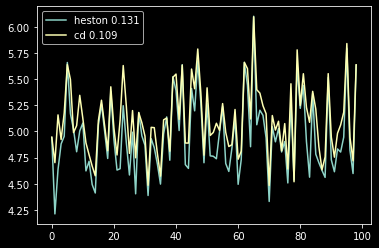

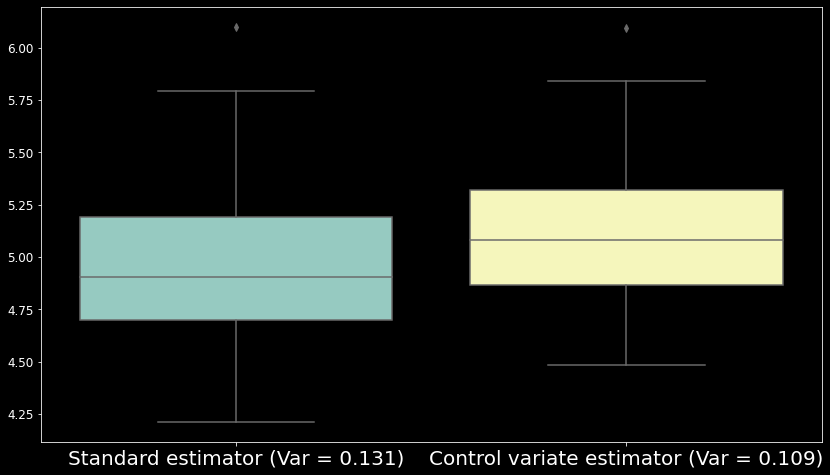

In [11]:
plt.style.use('dark_background')
plt.plot(price_ls_list)
plt.plot(price_cd_list)

plt.legend([f'heston {np.round(np.var(price_ls_list), 3)}', f'cd {np.round(np.var(price_cd_list), 3)}'])

import seaborn as sns



plt.figure(figsize=(14, 8))
sns.boxplot(data=results)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.tick_params(axis='x', which='major', labelsize=20)

In [ ]:
put = Option(s0=36, v0=0.04, T=1, K=40, call=False)
heston = HestonProcess(mu=0.06, kappa=0.0005, theta=0.04, eta=0.1, rho=-0.5)
europeen_put_price = heston_semi_closed(option=put, process=heston)

n = 100
price_ls_list = []
price_cd_list = []

for i in range(1, 100):

    price_mc, X = monte_carlo_simulation(option=put, process=heston, n=n, m=100, return_all=True, seed=i)
    price_ls, Y = monte_carlo_simulation_LS(option=put, process=heston, n=n, m=100, return_all=True, seed=i)

    cov = np.cov(X, Y)[0, 1]
    var_x = np.cov(X, Y)[1, 1]
    c_star = cov/var_x

    print(c_star)

    price_cd = price_ls - c_star * (price_mc - europeen_put_price)

    price_ls_list.append(price_ls)
    price_cd_list.append(price_cd)

results = pd.DataFrame({f'Standard estimator (Var = {np.round(np.var(price_ls_list), 3)})': price_ls_list, 
                        f'Control variate estimator (Var = {np.round(np.var(price_cd_list), 3)})': price_cd_list})

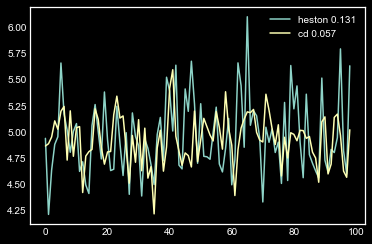

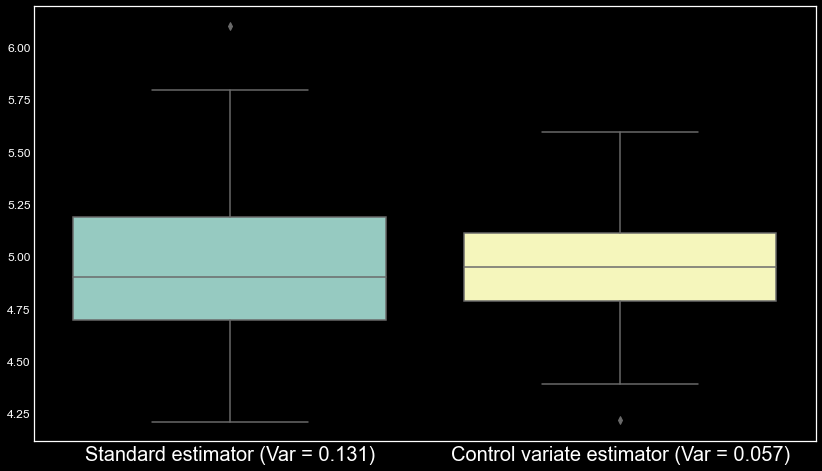

In [113]:
plt.style.use('dark_background')
plt.plot(price_ls_list)
plt.plot(price_cd_list)

plt.legend([f'heston {np.round(np.var(price_ls_list), 3)}', f'cd {np.round(np.var(price_cd_list), 3)}'])

import seaborn as sns

plt.figure(figsize=(14, 8))
sns.boxplot(data=results)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.tick_params(axis='x', which='major', labelsize=20)

In [6]:
put = Option(s0=36, v0=0.04, T=1, K=40, call=False)
heston = HestonProcess(mu=0.06, kappa=0.0005, theta=0.04, eta=0.1, rho=-0.5)


n = 100
price_list = []
price_antithetic_list = []

for i in range(1, 100):

    price = monte_carlo_simulation_LS(option=put, process=heston, n=n, m=20, seed=i)
    price_antithetic = monte_carlo_simulation_LS(option=put, process=heston, n=n, m=20, antithetic=True, seed=i)

    price_antithetic = (price + price_antithetic) / 2

    price_list.append(price)
    price_antithetic_list.append(price_antithetic)

results = pd.DataFrame({f'Standard estimator (Var = {np.round(np.var(price_list), 3)})': price_list, 
                        f'Antithetic estimator (Var = {np.round(np.var(price_antithetic_list), 3)})': price_antithetic_list})

plt.figure(figsize=(14, 8))
sns.boxplot(data=results)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.tick_params(axis='x', which='major', labelsize=20)

The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 5.0197
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.4084
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.7707
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 5.0411
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.7606
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.5311
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.9384
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.4353
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 5.2138
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.6549
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.3097
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 5.1422
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.7244
The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 5.0801
The price of Option(s0=36, T=1, K=40, v0=0.04, c

,Standard estimator (Var = 0.12),Antithetic estimator (Var = 0.018)
0,5.020,4.7140
1,4.771,4.9060
2,4.761,4.6460
3,4.938,4.6865
4,5.214,4.9345
...,...,...
94,4.687,4.8345
95,5.280,4.8240
96,4.320,4.4770
97,4.867,4.8790


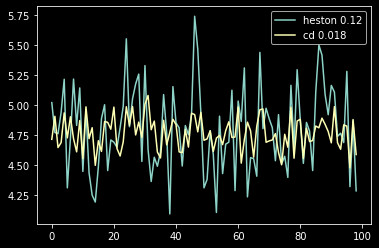

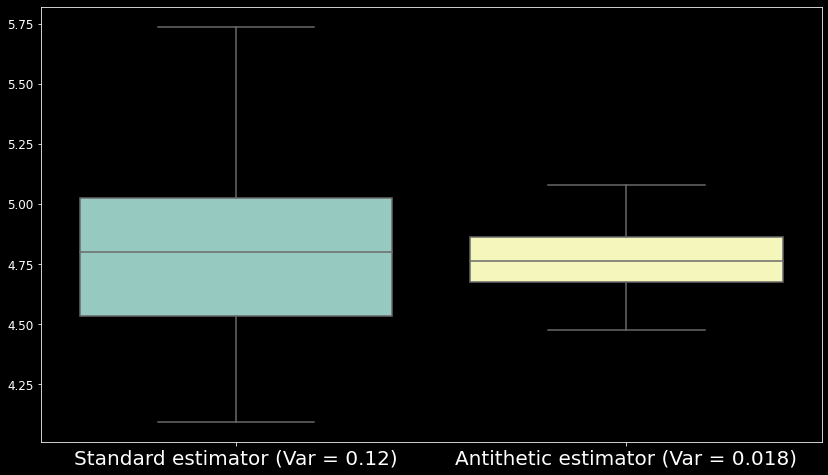

In [7]:
plt.style.use('dark_background')
plt.plot(price_list)
plt.plot(price_antithetic_list)

plt.legend([f'heston {np.round(np.var(price_list), 3)}', f'cd {np.round(np.var(price_antithetic_list), 3)}'])

import seaborn as sns

plt.figure(figsize=(14, 8))
sns.boxplot(data=results)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.tick_params(axis='x', which='major', labelsize=20)

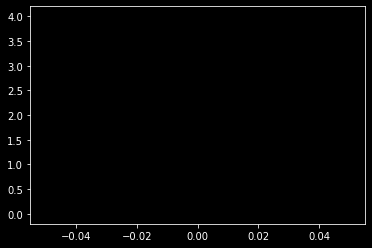

In [9]:
put = Option(s0=36, v0=0.04, T=1, K=40, call=False)
heston = HestonProcess(mu=0.06, kappa=0.0005, theta=0.04, eta=0.1, rho=-0.5)

%time monte_carlo_simulation_LS(option=put, process=heston, n=20000, m=100)

The price of Option(s0=36, T=1, K=40, v0=0.04, call=False) = 4.3382
Wall time: 6.71 s


4.338

Note: you may need to restart the kernel to use updated packages.
La syntaxe du nom de fichier, de r�pertoire ou de volume est incorrecte.


In [1]:
import pandas as pd 
import numpy as np 

date = "2021-02-18"
SX5E = 3681.04
VSTOXX = 22.5234
r =	0	
d =	0.04

df = pd.read_excel("Market_Data_SX5E.xlsx", usecols=range(1, 11), skiprows=10, skipfooter=1, header=0, index_col=0).round(2)
df.columns = [round(number * SX5E, 2) for number in df]
df.index = np.array([1, 2, 3, 6, 9, 12, 24, 36, 48, 60])/12
df = df/100

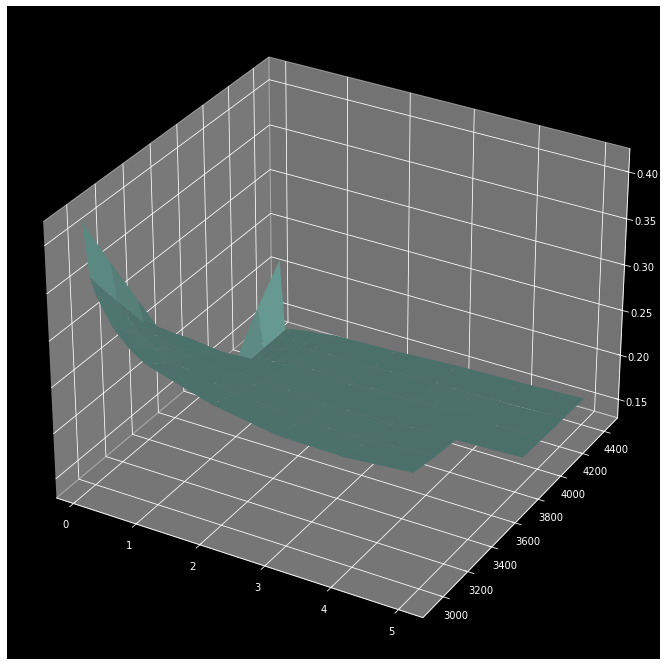

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(14, 12))
ax = plt.axes(projection='3d')
X, Y = np.meshgrid(df.index, df.columns)

ax.plot_surface(X.T, Y.T, df.values)

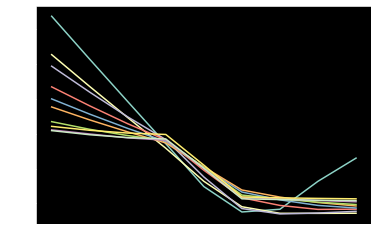

In [3]:
for i in range(len(df)):
    plt.plot(df.columns, df.iloc[i])

In [4]:
df

,2944.83,3128.88,3312.94,3496.99,3681.04,3865.09,4049.14,4233.19,4417.25
0.083333,0.4189,0.3571,0.2962,0.2357,0.1741,0.1376,0.1415,0.1817,0.2150
0.166667,0.3637,0.3179,0.2732,0.2292,0.1817,0.1451,0.1357,0.1356,0.1358
0.250000,0.3471,0.3098,0.2742,0.2416,0.1879,0.1425,0.1348,0.1361,0.1385
0.500000,0.3174,0.2901,0.2644,0.2411,0.1976,0.1580,0.1470,0.1413,0.1416
0.750000,0.3001,0.2782,0.2577,0.2389,0.2017,0.1663,0.1550,0.1470,0.1433
1.000000,0.2885,0.2699,0.2527,0.2368,0.2023,0.1692,0.1590,0.1512,0.1462
2.000000,0.2674,0.2564,0.2474,0.2405,0.2016,0.1619,0.1563,0.1517,0.1483
3.000000,0.2556,0.2497,0.2441,0.2407,0.2003,0.1587,0.1562,0.1541,0.1522
4.000000,0.2545,0.2486,0.2445,0.2425,0.2003,0.1565,0.1554,0.1545,0.1538
5.000000,0.2606,0.2550,0.2510,0.2490,0.2049,0.1592,0.1579,0.1571,0.1565


In [384]:
from itertools import product
import pandas as pd
import numpy as np
from option import Option
from process import HestonProcess
from pricing import black_scholes_merton#, heston_semi_closed

SX5E = 3681.04
VSTOXX = 0.225234
EURIBOR_3M = -0.543

df = pd.read_excel("Market_Data_SX5E.xlsx", usecols=range(1, 11), skiprows=10, skipfooter=1, header=0, index_col=0).round(2)
df.columns = [round(moneyness * SX5E, 2) for moneyness in df]
df.index = np.array([1, 2, 3, 6, 9, 12, 24, 36, 48, 60])/12
df = df/100

In [526]:
import time
from itertools import product 
import numpy as np 

def J(heston_param, *params):
    print('Function call')
    kappa, theta, eta, rho = heston_param
    df, = params
    
    heston = HestonProcess(mu=0, kappa=kappa, theta=theta, eta=eta, rho=rho)
    errors = []
    for T, K in product(df.index, df):

        option = Option(s0=SX5E, v0=VSTOXX**2, T=T, K=K, call=True)
        model_price = heston_semi_closed(option=option, process=heston)
        market_price = black_scholes_merton(r=0, sigma=df.loc[T, K], option=option)

        if model_price < 0 or model_price is np.nan:
            print(kappa, theta, eta, rho, T, K, model_price)

        errors.append(np.abs(model_price - market_price) / market_price)
    return max(errors)

In [553]:
%%time 

from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint

constrainst = lambda x: 2*x[0]*x[1] - x[2]**2
nlc = NonlinearConstraint(constrainst, 0, np.inf)

result = minimize(
    J_fast, 
    x0=np.array([ 0.387,  0.165,  0.2, -0.4547]), 
    args=(df.values, df.index.values, df.columns.values),
    # method='Nelder-Mead',
    bounds=(
        (0.01, 3), 
        (0.01, 0.4), 
        (0.01, 3), 
        (-.9, 1)
    ),
    tol=1e-3,
    # constraints=nlc
)

print(result.x)
print(result.fun)

[ 0.36578245  0.2843245   0.95942299 -0.707969  ]
34.91222522348393
Wall time: 28.9 ms


In [550]:
from scipy.optimize import brute 

rranges = (
    (1e-5, 10), 
    (1e-5, 0.5), 
    (1e-5, 10), 
    (-1, 1)
)

%time result = brute(J_fast, rranges, args=(df.values, df.index.values, df.columns.values), Ns=30)

print(J_fast(result, df.values, df.index.values, df.columns.values))
result

Wall time: 37.4 s
30.726264355199472


array([ 0.37654937,  0.06404928,  0.13645577, -3.39737174])

In [549]:
from scipy import optimize 

from scipy.optimize import NonlinearConstraint

constrainst = lambda x: 2*x[0]*x[1] - x[2]**2
nlc = ({'type': 'ineq', 'fun': constrainst})

result = optimize.shgo(
    J_fast, 
    args=(df.values, df.index.values, df.columns.values),
    bounds=(
        (1e-5, 10), 
        (1e-5, 0.5), 
        (1e-5, 10), 
        (-1, 1)
    ),
    # constraints=nlc,
    options={'f_tol': 1e-9}
)

result

     fun: 31.684057575462045
    funl: array([31.68405758])
 message: 'Optimization terminated successfully.'
    nfev: 171
     nit: 2
   nlfev: 154
   nlhev: 0
   nljev: 28
 success: True
       x: array([ 0.39535678,  0.13239354,  0.5552411 , -1.        ])
      xl: array([[ 0.39535678,  0.13239354,  0.5552411 , -1.        ]])

In [496]:
df_model = pd.DataFrame(np.zeros(df.shape))

for i, T in enumerate(df.index):
    for j, K in enumerate(df):
        heston = HestonProcess(*[0, 1.42631579,  0.01      ,  0.95421053, -0.58947368])
        option = Option(s0=SX5E, v0=VSTOXX**2, T=T, K=K, call=True)
        df_model.iloc[i, j] = heston_semi_closed(option=option, process=heston)

df_model

quad time 0.0146
quad time 0.015
heston semi closed time 0.0303
quad time 0.0141
quad time 0.0136
heston semi closed time 0.0284
quad time 0.0061
quad time 0.0085
heston semi closed time 0.0154
quad time 0.0088
quad time 0.0061
heston semi closed time 0.0183
quad time 0.0076
quad time 0.007
heston semi closed time 0.0162
quad time 0.0079
quad time 0.0053
heston semi closed time 0.0147
quad time 0.0101
quad time 0.0039
heston semi closed time 0.0153
quad time 0.0095
quad time 0.0051
heston semi closed time 0.0155
quad time 0.0039
quad time 0.0077
heston semi closed time 0.0138
quad time 0.0127
quad time 0.0099
heston semi closed time 0.0232
quad time 0.0126
quad time 0.009
heston semi closed time 0.0241
quad time 0.0076
quad time 0.0066
heston semi closed time 0.015
quad time 0.0057
quad time 0.0061
heston semi closed time 0.0127
quad time 0.0047
quad time 0.0066
heston semi closed time 0.0123
quad time 0.0063
quad time 0.0041
heston semi closed time 0.0113
quad time 0.0036
quad time 0.

,0,1,2,3,4,5,6,7,8
0,737.157091,555.640772,379.487488,217.340267,87.221576,18.258270,2.456289,0.293964,0.034306
1,743.162907,567.035756,398.335488,242.985791,112.973730,34.795001,9.424674,2.665126,0.781627
2,751.132281,578.418233,412.914460,259.257498,128.243099,46.036252,16.009019,6.100499,2.460040
3,770.324264,601.122261,438.061170,285.249507,153.058652,65.974096,29.612952,15.116105,8.347016
4,781.442666,613.235620,451.000271,298.889434,166.960041,77.744822,37.888675,21.058708,12.742075
5,788.483144,621.005519,459.592337,308.411565,177.155452,86.554061,43.910937,25.282755,15.875676
6,805.242577,640.733545,482.902956,335.812550,207.740922,113.891889,62.319223,37.371255,24.292964
7,818.594628,657.004180,502.598573,359.234318,233.988257,138.421509,79.958534,48.953100,32.091043
8,831.487261,672.649829,521.385292,381.304695,258.483872,161.970862,98.195167,61.502240,40.682165
9,844.147334,687.898440,539.515700,402.351433,281.649311,184.654719,116.808129,74.976006,50.151542


In [497]:
df_price = pd.DataFrame(np.zeros(df.shape))

for i, T in enumerate(df.index):
    for j, K in enumerate(df):
        option = Option(s0=SX5E, T=T, K=K, call=True)
        df_price.iloc[i, j] = black_scholes_merton(r=0, sigma=df.loc[T, K], option=option)

df_price

,0,1,2,3,4,5,6,7,8
0,741.270,560.743,383.766,215.847,73.798,7.928,0.523,0.246,0.119
1,750.415,574.304,404.084,245.564,108.908,25.751,3.720,0.406,0.030
2,762.953,591.930,428.835,280.212,137.917,39.385,9.246,1.971,0.368
3,798.205,636.728,484.629,346.752,205.021,91.814,39.036,14.488,5.462
4,828.395,673.609,528.570,396.736,256.192,136.859,72.704,34.586,15.707
5,855.104,705.367,565.586,438.153,296.576,172.833,103.460,57.214,29.951
6,947.595,813.688,691.290,582.119,417.270,259.606,187.074,130.847,89.517
7,1019.145,898.965,787.321,689.072,506.931,326.868,257.214,199.903,153.299
8,1094.929,979.155,874.808,783.473,584.380,382.839,315.335,258.180,210.363
9,1180.703,1070.184,970.105,882.302,666.994,445.940,376.951,318.219,267.954


In [498]:
((df_price - df_model).abs()/df_price).mul(100).round(1)

,0,1,2,3,4,5,6,7,8
0,0.6,0.9,1.1,0.7,18.2,130.3,369.7,19.5,71.2
1,1.0,1.3,1.4,1.0,3.7,35.1,153.4,556.4,2505.4
2,1.5,2.3,3.7,7.5,7.0,16.9,73.1,209.5,568.5
3,3.5,5.6,9.6,17.7,25.3,28.1,24.1,4.3,52.8
4,5.7,9.0,14.7,24.7,34.8,43.2,47.9,39.1,18.9
5,7.8,12.0,18.7,29.6,40.3,49.9,57.6,55.8,47.0
6,15.0,21.3,30.1,42.3,50.2,56.1,66.7,71.4,72.9
7,19.7,26.9,36.2,47.9,53.8,57.7,68.9,75.5,79.1
8,24.1,31.3,40.4,51.3,55.8,57.7,68.9,76.2,80.7
9,28.5,35.7,44.4,54.4,57.8,58.6,69.0,76.4,81.3


In [521]:
(df_price - df_model).pow(2).mean().mean()**0.5

170.45762227032534

In [73]:
from scipy.integrate import quad
from numba import jit
import time


@jit(nopython=True)
def caracteristic_function(j: int, phi: float, t: float, v0: float, mu: float, 
                            kappa: float, theta: float, eta: float, rho: float) -> float:

    if j == 1:
        u = 1/2
        b = kappa - rho*eta
    else:
        u = -1/2
        b = kappa

    a = kappa*theta
    M = b - rho*eta*phi*1j
    d = np.sqrt(M**2 - eta**2 * (2*u*phi*1j - phi**2))
    g = (M + d) / (M - d)
    g_new = 1/g

    C = mu*phi*1j*t + (a/eta**2) * ((M - d)*t - 2*np.log((1 - g_new*np.exp(-d*t)) / (1 - g_new)))
    D = (M - d) / eta**2 * (1 - np.exp(-d*t)) / (1 - g_new*np.exp(-d*t))

    cf = np.exp(C + D*v0)

    return cf
    
def heston_semi_closed(option, process):
    t0h = time.perf_counter()
    # def caracteristic_function(j: int, phi: float, t: float, v0: float, mu: float, 
    #                            kappa: float, theta: float, eta: float, rho: float) -> float:

    #     if j == 1:
    #         u = 1/2
    #         b = kappa - rho*eta
    #     else:
    #         u = -1/2
    #         b = kappa

    #     a = kappa*theta
    #     M = b - rho*eta*phi*1j
    #     d = np.sqrt(M**2 - eta**2 * (2*u*phi*1j - phi**2))
    #     g = (M + d) / (M - d)

    #     C = mu*phi*1j*t + (a/eta**2) * ((M + d)*t - 2*np.log((1 - g*np.exp(d*t)) / (1 - g)))
    #     D = (M + d) / eta**2 * (1 - np.exp(d*t)) / (1 - g*np.exp(d*t))

    #     cf = np.exp(C + D*v0)

    #     return cf

    def P(cf, K: float, j: int) -> float:

        func = lambda phi: np.real(np.exp(-phi*np.log(K)*1j) / (phi*1j) * cf(j=j, phi=phi))
        t0 = time.perf_counter()
        ret =  1/2 + 1/np.pi * quad(func, 1e-15, 2000, limit=2000)[0]
        print('quad time', round(time.perf_counter() - t0, 4))

        return ret


    cf = lambda j, phi: caracteristic_function(j=j,
                                               phi=phi,
                                               t=option.T,
                                               v0=option.v0,
                                               mu=process.mu,
                                               theta=process.theta,
                                               eta=process.eta,
                                               kappa=process.kappa,
                                               rho=process.rho)

    Pj = lambda j: P(cf=cf, K=option.K/option.s0, j=j)

    price = option.s0 * Pj(j=1) - option.K * np.exp(-process.mu*option.T) * Pj(j=2)

    if not option.call:
        price = price - option.s0 + option.K * np.exp(-process.mu*option.T)

    print('heston semi closed time', round(time.perf_counter() - t0h, 4))
    return np.round(price, 10)

In [84]:
heston_1 = HestonProcess(mu=0, kappa=0.01, theta=0.01, eta=1.5050000000000001, rho=-0.8)
put_1 = Option(s0=3681.04, v0=0.225234**2, T=0.08333333333333333, K=4233.19, call=True)

heston_semi_closed(option=put_1, process=heston_1)

quad time 1.4254
quad time 0.0113
heston semi closed time 1.4379


0.0533962102

In [85]:
heston_1 = HestonProcess(0, 0.08546466429049975, 0.3556106881210193, 0.5445307912856556, -0.9518949004094319)
put_1 = Option(s0=3681.04, v0=0.225234**2, T=0.08333333333333333, K=4417.25, call=True)

heston_semi_closed(option=put_1, process=heston_1)

quad time 0.0088
quad time 0.0084
heston semi closed time 0.0176


2.1e-09

In [86]:
heston_1 = HestonProcess(0, 0.1, 0.1, 5, -1)
put_1 = Option(s0=3681.04, v0=0.225234**2, T=0.08333333333333333, K=4417.25, call=True)

heston_semi_closed(option=put_1, process=heston_1)

quad time 1.2881
quad time 0.036
heston semi closed time 1.3252


-0.1560067256

In [87]:
heston_1 = HestonProcess(0, 0.12926907559950312, 0.10197612782581685, 1.8274417789410302, -0.9893525728013981)
put_1 = Option(s0=3681.04, v0=0.225234**2, T=0.16666666666666666, K=4417.25, call=True)

heston_semi_closed(option=put_1, process=heston_1)

quad time 0.0454
quad time 0.0401
heston semi closed time 0.0858


-0.0001286276

In [523]:
import math
from numba import njit, vectorize

@jit(nopython=True)
def heston_semi_closed_fast(s0, v0, T, K, r, kappa, theta, eta, rho):

    Dt = math.exp(-kappa*T)
    X = math.log(s0)
    v = math.sqrt(theta + (v0 - theta)/(kappa*T)*(1 - Dt))
    d1 = 1 /(v*math.sqrt(T)) * (math.log(s0/K) + (r + v**2/2) * T)
    d2 = d1 - v * math.sqrt(T)

    Rt = (
        eta**2/(8*kappa**2) * (
            theta*T + (v0-theta)/kappa*(1-Dt) - 2*theta/kappa*(1-Dt) 
            - 2*(v0-theta)*T*Dt + theta/(2*kappa)*(1-Dt**2) 
            + (v0-theta)/kappa*(Dt-Dt**2)
        )
    )
    Ut = (
        rho*eta/(2*kappa**2) * (
            theta*kappa*T - 2*theta + v0 + Dt * (2*theta - v0) - kappa*T*Dt*(v0 - theta)
            )
        )

    H = math.exp(X)/(v*math.sqrt(2*math.pi*T)) * math.exp(-d1**2/2) * (1 - d1/(v*math.sqrt(T)))
    Kf = math.exp(X)/(v*math.sqrt(2*math.pi*T)) * math.exp(-d1**2/2) * (d1**2 - v*d1*math.sqrt(T) - 1)/(v**2*T)

    A1 = 0.31938153
    A2 = -0.356563782
    A3 = 1.781477937
    A4 = -1.821255978
    A5 = 1.330274429
    RSQRT2PI = 0.39894228040143267793994605993438

    K1 = 1.0 / (1.0 + 0.2316419 * abs(d1))
    K2 = 1.0 / (1.0 + 0.2316419 * abs(d2))

    ret_val1 = RSQRT2PI * math.exp(-0.5 * d1 * d1) * (K1 * (A1 + K1 * (A2 + K1 * (A3 + K1 * (A4 + K1 * A5)))))
    ret_val2 = RSQRT2PI * math.exp(-0.5 * d2 * d2) * (K2 * (A1 + K2 * (A2 + K2 * (A3 + K2 * (A4 + K2 * A5)))))
    
    norm_cdf_d1 = 1.0 - ret_val1 if d1 > 0 else ret_val1
    norm_cdf_d2 = 1.0 - ret_val2 if d2 > 0 else ret_val2

    bs = s0 * norm_cdf_d1 - K * math.exp(-r * T) * norm_cdf_d2

    return bs + H * Ut + Kf * Rt

@jit(nopython=True)
def black_scholes_merton_fast(s0, T, K, r, sigma):

    d1 = 1 /(sigma*math.sqrt(T)) * (math.log(s0/K) + (r + sigma**2/2) * T)
    d2 = d1 - sigma * math.sqrt(T)
    A1 = 0.31938153
    A2 = -0.356563782
    A3 = 1.781477937
    A4 = -1.821255978
    A5 = 1.330274429
    RSQRT2PI = 0.39894228040143267793994605993438

    K1 = 1.0 / (1.0 + 0.2316419 * abs(d1))
    K2 = 1.0 / (1.0 + 0.2316419 * abs(d2))

    ret_val1 = RSQRT2PI * math.exp(-0.5 * d1 * d1) * (K1 * (A1 + K1 * (A2 + K1 * (A3 + K1 * (A4 + K1 * A5)))))
    ret_val2 = RSQRT2PI * math.exp(-0.5 * d2 * d2) * (K2 * (A1 + K2 * (A2 + K2 * (A3 + K2 * (A4 + K2 * A5)))))
    
    norm_cdf_d1 = 1.0 - ret_val1 if d1 > 0 else ret_val1
    norm_cdf_d2 = 1.0 - ret_val2 if d2 > 0 else ret_val2

    return s0 * norm_cdf_d1 - K * math.exp(-r * T) * norm_cdf_d2

import time
from itertools import product 
import numpy as np 

@jit(nopython=True)
def J_fast(heston_param, *params):
    kappa, theta, eta, rho = heston_param
    vol_surface, maturity, strike = params
    errors = np.zeros_like(vol_surface)

    for (Ti, Kj), sigma in np.ndenumerate(vol_surface):
        T = maturity[Ti]
        K = strike[Kj]
        model_price = heston_semi_closed_fast(s0=SX5E, v0=VSTOXX**2, T=T, K=K, r=0, kappa=kappa, theta=theta, eta=eta, rho=rho)
        market_price = black_scholes_merton_fast(s0=SX5E, T=T, K=K, r=0, sigma=sigma)

        # errors[Ti, Kj] = np.abs(model_price - market_price) / market_price
        errors[Ti, Kj] = model_price - market_price

    return np.sqrt(np.mean(errors**2))

In [380]:
%%timeit

black_scholes_merton_fast(
    s0=100, 
    T=10, 
    K=70, 
    r=0.08, 
    sigma=0.2
)

1.09 µs ± 81.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [381]:
# %%timeit

heston_semi_closed_fast(
    s0=100, 
    v0=0.04, 
    T=10, 
    K=70, 
    r=0.08, 
    kappa=3, 
    theta=0.09, 
    eta=0.3, 
    rho=-0.6
)

71.33347291185193

In [522]:
J_fast([ 0.387,  0.165,  0.2, -0.4547], df.values, df.index.values, df.columns.values)

194.4757329017201

In [271]:
process = HestonProcess(mu=0.08, kappa=3, theta=0.09, eta=0.3, rho=-0.6)
option = Option(s0=100, v0=0.04, T=10, K=70)
heston_semi_closed(option, process)

quad time 0.0125
quad time 0.0087
heston semi closed time 0.0216


71.3167581635